<a href="https://colab.research.google.com/github/gandhisamay/FashionMNIST-Classification/blob/main/Semantic_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [103]:
# !pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp37-none-any.whl size=7411 sha256=eddfa2d8ea7bd6ec2a3eb5084431c9b9d265f3780426cfdc8744120eeb7e32b0
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 9.9 GB  | Proc size: 6.3 GB
GPU RAM Free: 13915MB | Used: 1194MB | Util   8% | Total 15109MB


In [ ]:
%cd '/content/drive/MyDrive/Datasets /Semantic Drone Dataset'

/content/drive/MyDrive/Datasets /Semantic Drone Dataset


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
from PIL import Image
%matplotlib inline

In [ ]:
import torch 
import torch.nn as nn 
from torch.utils.data import DataLoader,Dataset,random_split
from torchvision import transforms 
from torchvision import datasets
import torchvision.transforms.functional as TF
import torch.nn.functional as F

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LR = 1e-4

Text(0.5, 1.0, 'Label with mask')

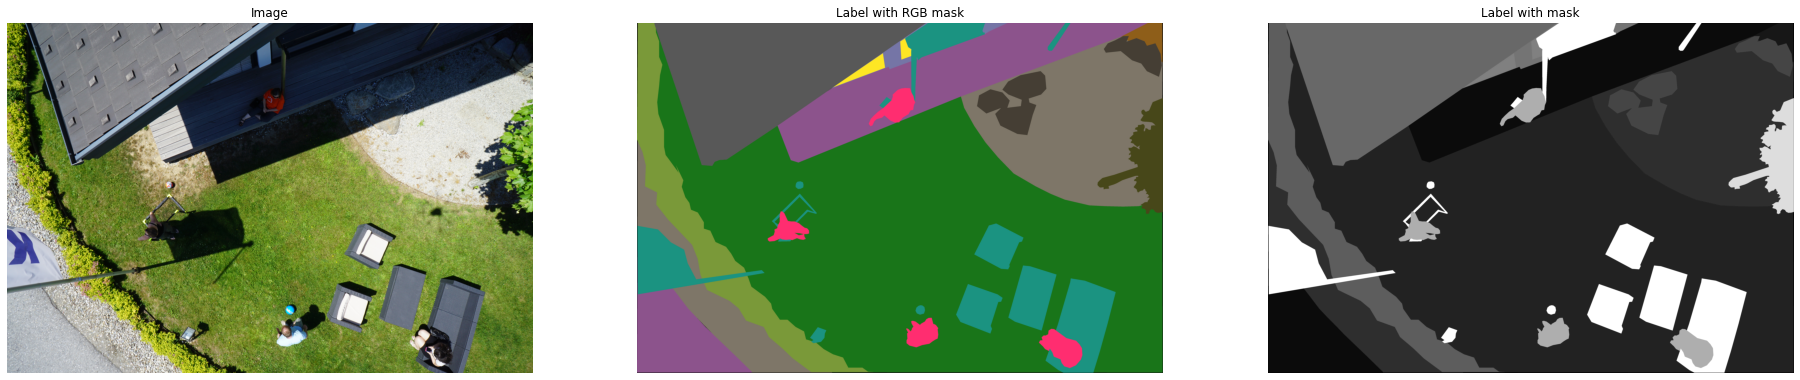

In [ ]:
#Viewing the images
images = 'dataset/semantic_drone_dataset/Original_Images'
rgb_masks = 'RGB_color_image_masks'
labels = 'dataset/semantic_drone_dataset/Labels'

image = Image.open(images + '/original_images/594.jpg')
rgb_mask = Image.open(rgb_masks + '/RGB_color_image_masks/594.png')
label = Image.open(labels + '/label_images_semantic/594.png')

fig = plt.figure(figsize=(32,32))
rows = 1
columns = 3

fig.add_subplot(rows,columns,1)
plt.imshow(image)
plt.axis('off')
plt.title("Image")

fig.add_subplot(rows,columns,2)
plt.imshow(rgb_mask,alpha=0.9)
plt.axis('off')
plt.title("Label with RGB mask")

fig.add_subplot(rows,columns,3)
plt.imshow(label, cmap='gray')
plt.axis('off')
plt.title("Label with mask")

In [ ]:
color_scheme = pd.read_csv('class_dict_seg.csv')

In [ ]:
color_scheme

,name,r,g,b
0,unlabeled,0,0,0
1,paved-area,128,64,128
2,dirt,130,76,0
3,grass,0,102,0
4,gravel,112,103,87
5,water,28,42,168
6,rocks,48,41,30
7,pool,0,50,89
8,vegetation,107,142,35
9,roof,70,70,70


In [ ]:
class DroneDataset(Dataset):
  def __init__(self,images_path,labels_path):
    self.images = datasets.ImageFolder(images_path,
                                       transform=transforms.Compose([
                                          transforms.Resize((400,600)),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                                       ]))
    self.labels = datasets.ImageFolder(labels_path,transform=transforms.Compose([
                                          transforms.Resize((400,600)),
                                          transforms.ToTensor()
    ]))

  def __getitem__(self,index): 
    return self.images[index][0],255*self.labels[index][0]
  
  def __len__(self):
    return len(self.images)

In [ ]:
dataset = DroneDataset(images,labels)

In [ ]:
dataset[0]

(tensor([[[-0.3541, -0.1999, -0.2171,  ..., -1.7069, -1.7069, -1.7240],
          [-0.4739, -0.3198, -0.3198,  ..., -1.7069, -1.7069, -1.7240],
          [-0.8335, -0.5938, -0.1486,  ..., -1.7240, -1.7240, -1.7412],
          ...,
          [-0.1657, -0.2684, -0.1314,  ..., -0.3541, -0.4226, -0.4226],
          [-0.1486, -0.1657, -0.0287,  ..., -0.2171, -0.2856, -0.2171],
          [-0.1657, -0.1828,  0.0227,  ..., -0.0972, -0.3198, -0.2684]],
 
         [[-0.0924,  0.0651,  0.0651,  ..., -1.5105, -1.5105, -1.5455],
          [-0.1800, -0.0924, -0.0924,  ..., -1.5455, -1.5805, -1.5980],
          [-0.4251, -0.2500,  0.0826,  ..., -1.5630, -1.5980, -1.5980],
          ...,
          [ 0.1001,  0.0126,  0.1527,  ..., -0.1450, -0.1975, -0.1450],
          [ 0.1001,  0.1176,  0.3102,  ...,  0.0301, -0.0574,  0.0651],
          [ 0.0651,  0.0651,  0.3277,  ...,  0.1877, -0.1275, -0.0749]],
 
         [[-1.2467, -1.2641, -1.1944,  ..., -1.0376, -1.0550, -1.1073],
          [-1.2816, -1.2119,

In [ ]:
#Split the data into train and val dataset
n_val = 10

train_dataset,val_dataset = random_split(dataset,[len(dataset)-n_val,n_val],generator=torch.Generator().manual_seed(42))

In [ ]:
#Make the data_loader now so that the data is ready for training
batch_size = 4

train_loader = DataLoader(train_dataset,batch_size)
test_loader  = DataLoader(val_dataset,batch_size*2)

In [ ]:
#Define the CNN block now
#Defined as per the U-net Structure 
#Made some modifications too to the original structure
class DoubleCNNBlock(nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            padding=1,
            stride=1,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(
            out_channels
        )
        self.act1 = nn.ReLU()
        self.conv2 = nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=3,
            padding=1,
            stride=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(
            out_channels
        )
        self.act2 = nn.ReLU() 
    def forward(self,x):
        out = self.act1(self.bn1(self.conv1(x)))
        out = self.act2(self.bn2(self.conv2(out)))
        return out

In [ ]:
class UpConv(nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.tconv = nn.ConvTranspose2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=2,
            stride=2
        ) 

    def forward(self,x,skip_connection):
        out = self.tconv(x)
        if out.shape != skip_connection.shape:
            print("1")
            out = TF.resize(out ,size=skip_connection.shape[2:])
        out = torch.cat([skip_connection,out],axis = 1)
        return out

In [ ]:
class Bottom(nn.Module):
    def __init__(self,channels_bottom=[512,1024]):
        super().__init__()
        self.channels_bottom = channels_bottom
        self.conv1 = nn.Conv2d(
            in_channels=512,
            out_channels=1024,
            kernel_size=3,
            padding=1,
            stride=1,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(
            self.channels_bottom[1]
        )
        self.act1 = nn.ReLU()
        self.conv2 = nn.Conv2d(
            in_channels=self.channels_bottom[1],
            out_channels=self.channels_bottom[1],
            kernel_size=3,
            padding=1,
            stride=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(
            self.channels_bottom[1]
        )
        self.act2 = nn.ReLU()
        
        self.bottom = nn.Sequential(
            self.conv1,
            self.bn1,
            self.act1,
            self.conv2,
            self.bn2,
            self.act2
        )
    def forward(self,x):
#         out = self.act1(self.bn1(self.conv1(x)))
#         print("1:{}".format(out.shape))
#         out = self.act2(self.bn2(self.conv2(out)))
#         print("2:{}".format(out.shape))
        return self.bottom(x)

In [ ]:
class Unet(nn.Module):
    def __init__(self,num_classes,filters=[64,128,256,512],input_channels=3):
        super().__init__()
        self.contract = nn.ModuleList()
        self.expand   = nn.ModuleList()                      #64 - #128 - #256 - #512 - #1024 -#512
        self.filters  = filters
        self.input_channels = input_channels
        self.num_classes = num_classes 
        
        self.pool = nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )
        
        for filters in self.filters:
            self.contract.append(
                DoubleCNNBlock(
                    in_channels=input_channels,
                    out_channels=filters
                )
            )
            input_channels = filters
            
        for filters in reversed(self.filters):
            self.expand.append(
                UpConv(
                    in_channels=filters*2,
                    out_channels=filters
                )
            )
            self.expand.append(
                DoubleCNNBlock(
                    in_channels=filters*2,
                    out_channels=filters
                )
            )
            
        self.final = nn.Conv2d(
                    in_channels=self.filters[0],
                    out_channels=num_classes,
                    kernel_size=3,
                    padding=1,
                    stride=1
                    )
            
    def forward(self,x):
        skip_connections = []
        
        for downs in self.contract:
            out = downs(x)
            skip_connections.append(out)
            out   = self.pool(out)
            x = out
        
        bottom = Bottom()
        bottom.to(DEVICE)
        y = bottom(x)
        
        for idx in range(0,len(self.expand),2):
            skip_connection = skip_connections[len(skip_connections)-idx//2-1]
            y = self.expand[idx](y,skip_connection)
            y = self.expand[idx+1](y)
            
        return self.final(y)

In [ ]:
model = Unet(num_classes=23)
model.to(DEVICE)

Unet(
  (contract): ModuleList(
    (0): DoubleCNNBlock(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU()
    )
    (1): DoubleCNNBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU()
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU()
    )
    (2): DoubleCNNBlock(
      (conv1): Conv2d(128, 256, kernel_size=(3, 3

In [149]:
def DICEloss(preds,outputs,smooth=1):
  preds = F.softmax(preds,dim=1)
  outputs = outputs.to(torch.int64)
  preds = torch.argmax(preds,axis=1)
  intersection = (preds == outputs).sum()
  area = 2*preds.shape[1]*preds.shape[2]

  return 1 - ((2. * intersection + smooth)/(area))

In [ ]:
opt  = torch.optim.Adam(model.parameters(),lr = LR)

In [ ]:
!nvidia-smi

Tue May 25 05:04:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    27W /  70W |   1194MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [106]:
torch.save(model.state_dict(),'Saved Model ')

In [151]:
#Training the model
import time 
model.train()

num_epochs = 100
loss_per_iteration = []
iters = []

for epochs in tqdm(range(num_epochs)):
  tic = time.time()

  loss_per_epoch = 0.0

  for inputs,outputs in train_loader:
    inputs,outputs = inputs.to(DEVICE),outputs.to(DEVICE)
    preds = model(inputs)
    loss  = DICEloss(preds,outputs)
    loss.backward()
    opt.step()
    opt.zero_grad()
    loss_per_epoch += loss
    iters.append(epochs)
  
  toc = time.time()
  
  print("[{}/{}] Loss : {} Time Taken : {}".format(epochs,num_epochs,loss_per_epoch,(toc - tic)/1000))

  #Saving the model after every epoch
  torch.save(model.state_dict(),'Saved Model ')
  print("Saved the model...")

  0%|          | 0/100 [00:02<?, ?it/s]


RuntimeError: ignored